In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [2]:
# import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pickle
from sklearn.utils import shuffle

from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [19]:
# Create a blank Tokenizer with just English
nlp=English()
tokenizer = Tokenizer(nlp.vocab)

# Preprocessing

In [85]:
# Import data
post_data = pd.read_csv(r"KidneyData.csv")

In [86]:
data = pd.DataFrame(post_data)
display(data.head())
display(data.shape)

,Time,Delta,Gender,Race,Age,Blood Type,PosNeg,Smoke,Drug,Alcohol,AvgSleep,City
0,"Quantity[1, ""Days""]",alive,Boy,White,28,O,Neg,STrue,DFalse,AFalse,6,Seattle
1,"Quantity[5, ""Days""]",alive,Boy,Black,52,B,Pos,STrue,DTrue,ATrue,5,Seattle
2,"Quantity[7, ""Days""]",dead,Girl,Indigenious,63,O,Pos,SFalse,DFalse,ATrue,7,Baltimore
3,"Quantity[9, ""Days""]",alive,Girl,White,29,A,Neg,STrue,DTrue,ATrue,6,Atlanta
4,"Quantity[13, ""Days""]",alive,Girl,Indigenious,48,B,Neg,STrue,DFalse,AFalse,7,Houston


(863, 12)

In [87]:
data = data.drop(columns = ['Time'])

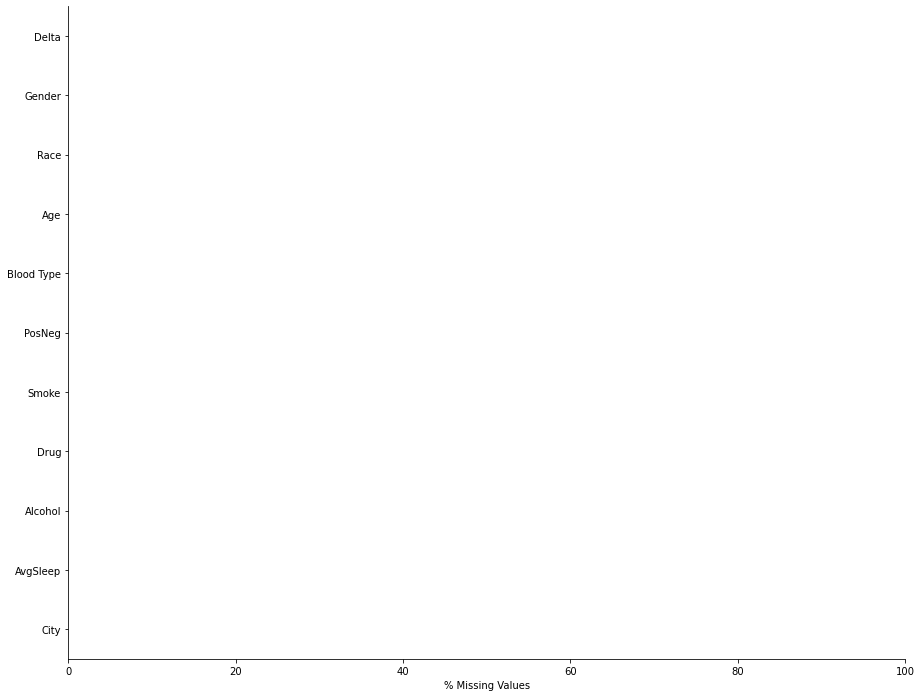

In [88]:
#plotting the percentage of missing values in each column
data_length = len(data)
data_null = (data.isnull().sum().sort_values(ascending=False)*100/len(data))
f, ax = plt.subplots(figsize=(15, 12))
sns.set_color_codes("pastel")
sns.set_color_codes("pastel")
ax.set(xlim=(0, 100), ylabel="",
       xlabel="% Missing Values")
sns.barplot(x=data_null.values, y=data_null.index, color="b")
sns.despine()

In [89]:
data.dtypes

Delta         object
Gender        object
Race          object
Age            int64
Blood Type    object
PosNeg        object
Smoke         object
Drug          object
Alcohol       object
AvgSleep       int64
City          object
dtype: object

In [91]:
data = data.astype({"Delta": str, "Gender": str, "Race": str, "Age": str, "Blood Type": str, "PosNeg": str, "Smoke": str, "Drug": str, "Alcohol": str, "AvgSleep": str, "City": str, })

In [92]:
data['category'] = data['City'].str.cat(data[['Gender','Race','Age','Blood Type','PosNeg','Smoke','Drug','Alcohol','AvgSleep']], sep=',')

In [93]:
data.head()

,Delta,Gender,Race,Age,Blood Type,PosNeg,Smoke,Drug,Alcohol,AvgSleep,City,category
0,alive,Boy,White,28,O,Neg,STrue,DFalse,AFalse,6,Seattle,"Seattle,Boy,White,28,O,Neg,STrue,DFalse,AFalse,6"
1,alive,Boy,Black,52,B,Pos,STrue,DTrue,ATrue,5,Seattle,"Seattle,Boy,Black,52,B,Pos,STrue,DTrue,ATrue,5"
2,dead,Girl,Indigenious,63,O,Pos,SFalse,DFalse,ATrue,7,Baltimore,"Baltimore,Girl,Indigenious,63,O,Pos,SFalse,DFa..."
3,alive,Girl,White,29,A,Neg,STrue,DTrue,ATrue,6,Atlanta,"Atlanta,Girl,White,29,A,Neg,STrue,DTrue,ATrue,6"
4,alive,Girl,Indigenious,48,B,Neg,STrue,DFalse,AFalse,7,Houston,"Houston,Girl,Indigenious,48,B,Neg,STrue,DFalse..."


# FEATURE EXTRACTION via tfidf vectorizer
### Create a data-term matrix (vocabulary)

In [94]:
# Instantiate vecorizer object - call tokenize
tf_model = TfidfVectorizer(max_features=200,max_df=0.25,min_df=0.01,stop_words='english')

In [95]:
# create corpus (categories) used for the TF-IDF
corpus = data['category']

In [96]:
tf_matrix = tf_model.fit_transform(corpus).todense()
print('The shape of the matrix is:', tf_matrix.shape)
tf_df = pd.DataFrame(tf_matrix)
tf_df.columns = sorted(tf_model.vocabulary_)
display(tf_df.head())

The shape of the matrix is: (863, 66)


,10,11,19,20,21,22,23,24,25,26,...,baltimore,detroit,fransisco,houston,new,phoenix,san,seattle,white,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.445664,0.370503,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.535496,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.541565,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.382646,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.541565,0.0,0.0,0.0,0.000000,0.000000,0.0


In [97]:
# Get cosine similarity of the matrix
cosine_sim = cosine_similarity(tf_matrix, tf_matrix)

In [98]:
# Fit on TF-IDF Vectors
nn = NearestNeighbors(n_neighbors=50, algorithm='ball_tree')
nn.fit(tf_matrix)

NearestNeighbors(algorithm='ball_tree', n_neighbors=50)

In [99]:
print(type(cosine_sim))

<class 'numpy.ndarray'>


In [100]:
# Pickle the dtm and tf for use in the prediction
pickle.dump(tf_matrix, open('tf_matrix.pkl', 'wb'))
pickle.dump(tf_model, open('tf_model.pkl', 'wb'))
np.save("cosine_sim.npy", cosine_sim)

# Test Case

In [117]:
# Create the test case
ideal_category = ['AB, Neg, Seattle']

new = tf_model.transform(ideal_category)
results = nn.kneighbors(new.todense())

In [118]:
results

(array([[0.65557555, 0.6825357 , 0.83248658, 0.83248658, 0.84381093,
         0.85191392, 0.85615649, 0.86507644, 0.86507644, 0.87466406,
         0.87974885, 0.88505462, 0.89060608, 0.89060608, 0.89084044,
         0.89643262, 0.89978643, 0.90524887, 0.90580819, 0.91568637,
         0.91872711, 0.91924455, 0.91924455, 0.92287867, 0.92683751,
         0.930906  , 0.9429438 , 0.94326758, 0.95031354, 0.95439172,
         0.96239557, 0.97615922, 0.981887  , 1.07375164, 1.07375164,
         1.07375164, 1.07375164, 1.08064825, 1.0855741 , 1.0855741 ,
         1.0855741 , 1.0855741 , 1.08815016, 1.08815016, 1.08815016,
         1.08815016, 1.08978341, 1.09080961, 1.09080961, 1.09355943]]),
 array([[167, 777,  81, 243, 283, 397, 487, 224, 439,  17, 800, 302, 382,
         821, 417, 610, 186, 718, 204, 267, 406, 498, 144, 599, 270, 479,
          47, 330,  38,  56, 451, 683, 733, 836, 663, 227, 520, 190,   1,
         681,  68, 797, 763, 638, 328, 294, 542, 365, 452,  64]],
       dtype=int64)

In [116]:
# displays the category of the first value of the first array 
data['category'][results[1][0][1]]

'Seattle,Boy,Black,32,AB,Neg,SFalse,DFalse,AFalse,7'

In [119]:
def give_recommended_TF(ideal_categories):
    ideal_category = [ideal_categories]
    new = tf_model.transform(ideal_category)
    results = nn.kneighbors(new.todense())
    display(data['category'][results[1][0][0]])

In [121]:
give_recommended_TF('Girl,New York,AFalse')

'New York,Girl,Black,58,A,Pos,SFalse,DTrue,AFalse,7'